# Transit photometry

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from scipy import ndimage
from matplotlib.patches import Circle, Wedge, Polygon
import utils as utl

## Loading an image

The data is stored in another directory -- we first want to load one of the files to see how it looks like. We use `astropy.io.fits` function to do so.

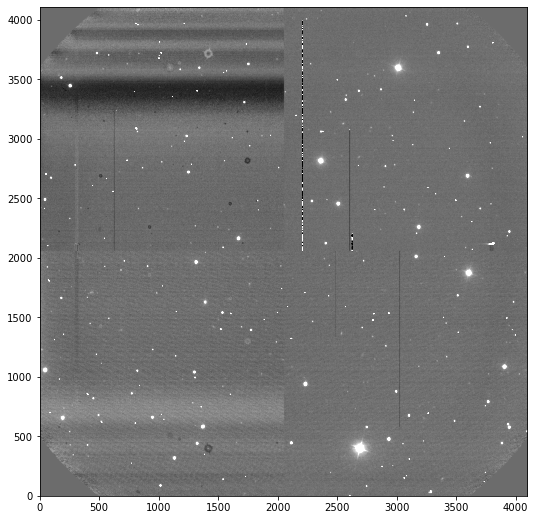

In [10]:
p1 = os.getcwd() + '/Data/'
lst = os.listdir(p1)
lst.sort(key = utl.natural_keys)
img_data = fits.getdata(p1 + lst[0])

# Plotting the data
fig, ax1 = plt.subplots(1, figsize=(9,9))
ax1.imshow(img_data, cmap='gray', vmin=0, vmax=60, origin='lower')

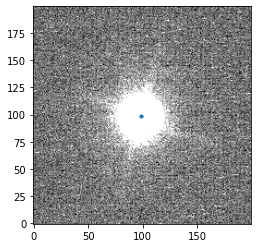

In [19]:
subimage = img_data[1775:1975, 3500:3700]
cenx, ceny = ndimage.measurements.center_of_mass(subimage)
fig, ax2 = plt.subplots(1)
ax2.imshow(subimage, cmap='gray', vmin=0, vmax=60, origin='lower')
ax2.scatter(cenx, ceny, 10)


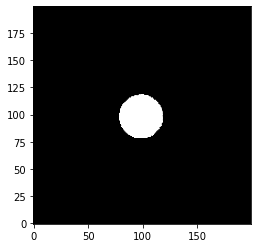

In [30]:
def aperture(image, distance=20):
    mask1 = np.zeros(image.shape)
    cen1, cen2 = ndimage.measurements.center_of_mass(image)
    for i in range(200):
        for j in range(200):
            dist = np.sqrt((i-cen1)**2 + (j-cen2)**2)
            if dist <= distance:
                mask1[i][j] = 1
            else:
                continue
    aper = mask1*image
    return aper

aper0 = aperture(subimage)
plt.imshow(aper0, cmap='gray', vmin=0, vmax=60, origin='lower')

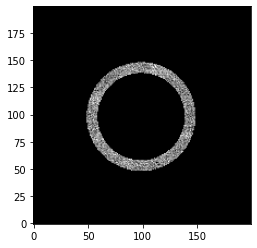

In [31]:
def sky_back(image, inner_rad=40, outer_rad=50):
    mask2 = np.zeros(image.shape)
    cen3, cen4 = ndimage.measurements.center_of_mass(image)
    for i in range(200):
        for j in range(200):
            dist = np.sqrt((i-cen3)**2 + (j-cen4)**2)
            if dist <= outer_rad and dist >= inner_rad:
                mask2[i][j] = 1
            else:
                continue
    sky3 = mask2*image
    return sky3

sky2 = sky_back(subimage)
plt.imshow(sky2, cmap='gray', vmin=0, vmax=60, origin='lower')

In [33]:
def sky(image, cenx, ceny, skyrado, skyradi):
    mask7 = np.zeros(image.shape)
    for i in range(200):
        for j in range(200):
            dist = np.sqrt((i-cenx)**2 + (j-ceny)**2)
            if dist>=skyradi and dist<=skyrado:
                mask7[i][j] = 1
    sky4 = mask7*image
    sky_flx = np.average(sky4)/np.sum(mask7)
    return sky_flx

def aperture_fl(image, cenx, ceny, rad, skyflux):
    mask8 = np.zeros(image.shape)
    for i in range(200):
        for j in range(200):
            dist = np.sqrt((i-cenx)**2 + (j-ceny)**2)
            if dist<= rad:
                mask8[i][j] = 1
    flx = (mask8*image) - (mask8*skyflux)
    ape_flx = np.sum(flx)
    return ape_flx

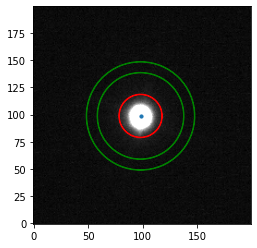

In [35]:
rad = 20
skyrad1 = 40
skyrad2 = 50

fig, ax3 = plt.subplots(1)
ax3.imshow(subimage, cmap='gray', vmin=0, vmax=600, origin='lower')
ax3.scatter(cenx, ceny, 10)
Aperture = Wedge((cenx, ceny), rad, 0, 360, width=0.5, color='red')
ax3.add_patch(Aperture)
Skuannulus1 = Wedge((cenx, ceny), skyrad1, 0, 360, width=0.5, color='green')
Skuannulus2 = Wedge((cenx, ceny), skyrad2, 0, 360, width=0.5, color='green')
ax3.add_patch(Skuannulus1)
ax3.add_patch(Skuannulus2)

In [36]:
print(cenx)
print(ceny)

98.13327213365415
98.73302925960428


In [62]:
def find_center(image, dist):
    img1 = aperture(image, distance=dist)
    cx1 = 0
    cy1 = 0
    for i in range(200):
        c1 = 0
        c9 = 0
        for j in range(200):
            # for cx
            c2 = i*img1[i,j]
            c1 = c1 + c2
            # for cy
            c8 = i*img1[j,i]
            c9 = c9 + c8
        cx1 = cx1 + c1
        cy1 = cy1 + c9
    cx = cx1/np.sum(img1)
    cy = cy1/np.sum(img1)
    return cy, cx

cx_n, cy_n = find_center(subimage, 20)
print(cx_n)
print(cy_n)

98.41596021773006
97.68919598291116


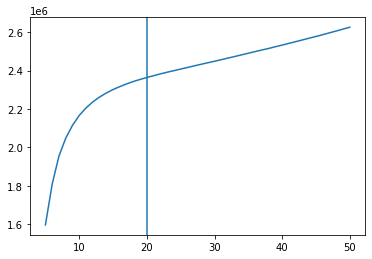

In [63]:
rads = np.arange(5,51,1)

skyflx = sky(image=subimage, cenx=cx_n, ceny=cy_n, skyrado=80, skyradi=70)

apr_rad = np.zeros(len(rads))

for i in range(len(rads)):
    apr_fl = aperture_fl(image=subimage, cenx=cx_n, ceny=cy_n, rad=rads[i], skyflux=skyflx)
    apr_rad[i] = apr_fl

plt.plot(rads, apr_rad)
plt.axvline(x=20)

In [64]:
times = np.zeros(len(lst))
flx = np.zeros(len(lst))
flx_err = np.zeros(len(lst))

for i in range(len(lst)):
    img_data1 = fits.getdata(p1 + lst[i])
    subimg1 = img_data1[1775:1975, 3500:3700]
    cx2, cy2 = find_center(image=subimg1, dist=25)
    skyflx2 = sky(image=subimg1, cenx=cx2, ceny=cy2, skyrado=80, skyradi=70)
    apr_fl2 = aperture_fl(image=subimg1, cenx=cx2, ceny=cy2, rad=25, skyflux=skyflx2)
    flx[i] =apr_fl2
    flx_err[i] = np.sqrt(apr_fl2)
    hdul = fits.open(p1 + lst[i])
    times[i] = hdul[0].header['MJD-OBS']

<ErrorbarContainer object of 3 artists>

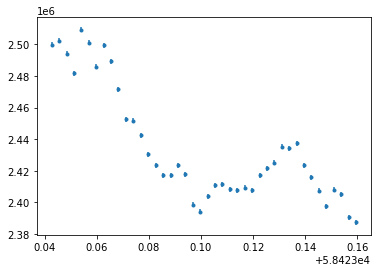

In [65]:
plt.errorbar(times, flx, yerr=flx_err, fmt='.')

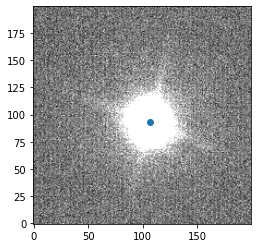

In [77]:
subimg22 = img_data[3500:3700, 2900:3100]
cenx4, ceny4 = find_center(subimg22, 25)
fig, ax4 = plt.subplots(1)
ax4.imshow(subimg22, cmap='gray', vmin=0, vmax=60, origin='lower')
ax4.scatter(cenx4, ceny4)

In [78]:
times_ref = np.zeros(len(lst))
flx_ref = np.zeros(len(lst))
flx_err_ref = np.zeros(len(lst))

for i in range(len(lst)):
    img_data1 = fits.getdata(p1 + lst[i])
    subimg1 = img_data1[3500:3700, 2900:3100]
    cx2, cy2 = find_center(image=subimg1, dist=25)
    skyflx2 = sky(image=subimg1, cenx=cx2, ceny=cy2, skyrado=80, skyradi=70)
    apr_fl2 = aperture_fl(image=subimg1, cenx=cx2, ceny=cy2, rad=25, skyflux=skyflx2)
    flx_ref[i] =apr_fl2
    flx_err_ref[i] = np.sqrt(apr_fl2)
    hdul = fits.open(p1 + lst[i])
    times_ref[i] = hdul[0].header['MJD-OBS']

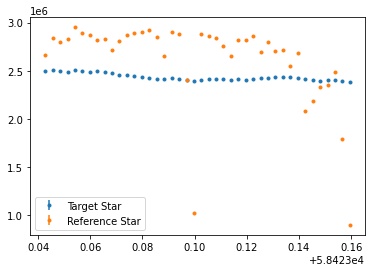

In [79]:
plt.errorbar(times, flx, yerr=flx_err, fmt='.', label='Target Star')
plt.errorbar(times_ref, flx_ref, yerr=flx_err_ref, fmt='.', label='Reference Star')
plt.legend(loc='best')

In [80]:
rel_pho, rel_pho_err = np.zeros(len(lst)), np.zeros(len(lst))

for i in range(len(lst)):
    flx_tar = np.random.normal(flx[i], flx_err[i], 10000)
    flx_re = np.random.normal(flx_ref[i], flx_err_ref[i], 10000)
    flx_rel = flx_tar/flx_re
    rel_pho[i], rel_pho_err[i] = np.mean(flx_rel), np.std(flx_rel)

<ErrorbarContainer object of 3 artists>

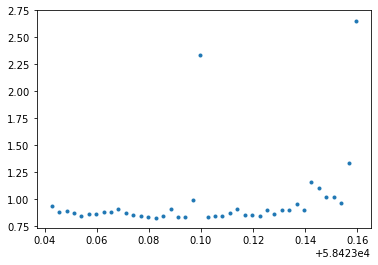

In [81]:
plt.errorbar(times, rel_pho, yerr=rel_pho_err, fmt='.')